<h2>Daniel Vasilyonok</h2>
<h3>Python for Data Science CSCI E - 29</h3>
<h3>Natural Language Identification Machine Learning Pipeline - Graduate Project</h3>

<p>
In this project, I pulled text data from European Parliament Proceedings in 21 languages.
Using Scikit-Learn, I transformed the raw text into a numerical feature matrix, and trained
a Multinomial naive bayes probability model to classify input language with greater than 99% accuracy.
</p>

<p> 
Data Source: http://www.statmt.org/europarl/    
</p>

In [1]:

# Required libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import sent_tokenize
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.utils import shuffle, resample

<h2>Helper Functions</h2>

In [2]:
# Helper Functions

def combine_text_files(language_code, language):
   
    '''
    Goal: Certain languages do not have a single file of length >= MAX_LENGTH_TRANSCRIPTION
          This function will combine these files for this sort of language into one language
          transcription, and then write the transcription to a single file.
    
    @param: (string) language_code is the 2 character code of the language
    @param: (string) language is the English name of the language         
    '''    
    
    file_name_list = os.listdir('language_data/txt/' + language_code + '/')
    language_transcription = ''
    for file_name in file_name_list:
        if(len(language_transcription) >= MAX_LENGTH_TRANSCRIPTION):
            break;
        path = os.getcwd() + '/language_data/txt/' + language_code + '/' + file_name
        with open(path) as f:
            contents = f.read()
            language_transcription += contents
    
    write_path = os.getcwd() + '/language_data/txt/' + language_code + '/' + language + '.txt'
    with open(write_path, 'w') as f:
        f.write(language_transcription)

def read_languages_data(path):
    '''
    Goal: Read language data from file path into a list containing one massive string
    
    @param path: (string) file path pointing to the raw natural language text
                 Original file data source found here: http://www.statmt.org/europarl/
    @return language_transcription: (list) language_transcription is a list of one string containing the whole text
    '''
    with open(path) as f:
        language_transcription = f.read()
        language_transcription = language_transcription[:MAX_LENGTH_TRANSCRIPTION]
    return language_transcription

def clean_sentences(sentences):
    '''
    Goal: Filter out non predictive text about speaker using regular expression pattern
    
    @param sentences: (list) sentences is a list of strings, where each string is a sentence.
                       Note: The raw language_transcription should be tokenized by sentence prior
                       to being passed into this function.
    '''
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(pattern,'',sentence)

def combine_language_data(sentences, language_index):
    '''
    Goal: Transform list of string sentences into np.array, and stack horizontally with an np.array containing 
          the sentence's language_index, which maps to the sentence language. Essentially, apply label to data.
    
    @param sentences: (list) sentences is a list of strings that has had speaker information filtered out
    @param language_index: (float) language_index is a float that maps to a specific language in the labels dictionary
    @return language_data: (np.array) return an np.array of shape (# of sample sentences, 2 )
    '''
    sentences = np.array(sentences)
    sentences = sentences.reshape(sentences.shape[0],1)
    target = np.zeros((sentences.shape[0],1))
    target += language_index
    language_data = np.hstack((sentences, target))
    return language_data

def test_languages(X_test, true_values, predictions):
    '''
    Goal: Visualize the ~99% prediction accuracy by comparing,
        1. natural language sentence
        2. predicted natural language
        3. true natural language
    
    @param X_test: (np.array) X_test is a np.array containing the unseen data from the test set
    @param true_values: (np.array) true_values is a np.array containing the true language_index labels
    @param predictions: (np.array) predictions is a np.array containing the predicted language_index labels
    '''
    
    true_values = np.array(true_values)
    
    for i, sentence in enumerate(X_test):
        prediction = float(predictions[i])
        true_value = float(true_values[i])
        print("Prediction: " + str(labels[prediction]))
        print("Actual Language: " + str(labels[true_value]))
        print("Input Sentence: ")
        print(sentence)
        print('\n')

def shuffle_rows(languages):
    '''
    Goal: Shuffle rows of 2D np.array with language data
    
    @param languages: un-mixed 2D np.array with language sentence features, and language_index labels
    @return shuffled_languages: shuffled by row, 2D np.array 
    '''
    
    index = np.arange(0, len(languages))
    np.random.shuffle(index)
    shuffled_languages = languages[index,:]

    return shuffled_languages
    
def preproccess_raw_data(file_paths):
    '''
    Goal: Run all data preprocessing helper functions
    
    @param file_paths: (list) file_paths is a list of string file paths. Each file path string
                        points to a raw text file from the European Parliament Proceedings.
    @return languages: (np.array) languages is a 2D np.array of shape (# sentences, 2)
                        The first dimension has the a sentence, and the second dimension
                        has the language_index label, that maps to the language.
    '''
    
    # Combine transcriptions of subset languages into a single file to ensure
    # each file will have len >= MAX_LENGTH_TRANSCRIPTION
    language_codes_files_subset = dict( (key, language_codes_files[key] ) for key in limited_raw_text if key in language_codes_files )
    for language in language_codes_files_subset.keys():
        combine_text_files(language_codes_files_subset[language][0], language)
    
    # Read all raw text data from file paths
    language_transcriptions = [ read_languages_data(path) for path in file_paths ]
    
    # tokenize each raw text string into a list of sentences
    for i, language_transcription in enumerate(language_transcriptions):
        language_transcriptions[i] = sent_tokenize(language_transcription)
    
    # Remove information about speakers using a regular expression pattern
    for sentences in language_transcriptions:
        clean_sentences(sentences)
    
    # Combine each language with its language_index
    languages = [ combine_language_data(sentences,i+1) for i,sentences in enumerate(language_transcriptions) ]
    
    # Vertically stack all data into one 2D np.array
    languages =  np.vstack((languages))
    
    # Shuffle languages by row
    languages = shuffle_rows(languages)
    
    return languages
    

In [3]:
#df_languages = pd.DataFrame(languages)
#df_languages.columns = ['natural language', 'language index']
#df_languages['language index'] = df_languages['language index'].apply(float)
#df_languages['language'] = df_languages['language index'].map(labels)
#print(df_languages.isnull().any())
#display(df_languages.head(10))

In [4]:
df_languages = pd.read_csv('lang_data.csv')

In [5]:
df_languages.head()

,text,language
0,Ship shape and Bristol fashion,English
1,Know the ropes,English
2,Graveyard shift,English
3,Milk of human kindness,English
4,Touch with a barge-pole - Wouldn't,English


In [6]:
df_languages.dropna(inplace=True)
df_languages.drop_duplicates(inplace=True)

In [7]:
import string
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Change to lower case
    3. Remove numbers
    4. Remove white space
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    nopunc = nopunc.lower()
    
    nopunc = re.sub(r'\d+', '', nopunc)
    
    return nopunc.strip()

In [8]:
df_languages['text'] = df_languages['text'].astype(str)
df_languages['text'] = df_languages['text'].apply(text_process)
df_languages.drop_duplicates(inplace=True)

In [9]:
df_languages.columns = ['natural language', 'language']
df_languages.data = df_languages['natural language']

C:\ProgramData\Anaconda3\envs\geron2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [10]:
# Shuffle to eliminate possible segreggation
# Random state to keep hold-out test set consistent
df_languages = shuffle(df_languages, random_state=0)

In [11]:
# 10% test set never to be touched till handin
df_languages = df_languages[:int(-0.1*len(df_languages))]
len(df_languages)

2460

In [12]:
# create binary labels
df_languages['language index'] = df_languages['language'].map({'English': 0, 'Afrikaans': 1, 'Nederlands': 2})

In [13]:
df_languages.head()

,natural language,language,language index
909,things that go bump in the night,English,0
2627,keep it under your hat,English,0
782,die laaitie se hakskene word rooi,Afrikaans,1
75,earmark,English,0
2196,bums on seats,English,0


In [14]:
df_languages.shape

(2460, 3)

In [15]:
# Split data into raw features and labels

language_features = df_languages['natural language']
language_targets = df_languages['language index']

Ensure Dataset is relativley balanced.

In [16]:
unique, counts = np.unique(language_targets, return_counts=True)
dict(zip(unique, counts))

{0: 1839, 1: 562, 2: 59}

In [17]:
# Split data into training and test set
# Train on 70% of data, Test on remaining 30%

X_train, X_test, y_train, y_test = train_test_split(language_features, 
                                                    language_targets,
                                                    test_size = 0.33,
                                                    random_state = 42)

In [18]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['language index'].value_counts()

0    1237
1     374
2      37
Name: language index, dtype: int64

In [19]:
class0 = train_df[train_df['language index'] == 0]
class1 = train_df[train_df['language index'] == 1]
class2 = train_df[train_df['language index'] == 2]
max = train_df['language index'].value_counts().max()

if len(train_df[train_df['language index'] == 0]) == max:
  majority = class0
  minority1 = class1
  minority2 = class2
elif len(train_df[train_df['language index'] == 1]) == max:
  minority1 = class0
  majority = class1
  minority2 = class2
else:
  minority1 = class0
  minority2 = class1
  majority = class2

In [20]:
new_minority1 = resample(minority1, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

new_minority2 = resample(minority2, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority1])
train_df = pd.concat([train_df, new_minority2])
train_df = shuffle(train_df, random_state=42)

train_df['language index'].value_counts()

1    1237
2    1237
0    1237
Name: language index, dtype: int64

In [21]:
y_train = train_df['language index']
X_train= train_df['natural language']

<h2>Machine Learning Pipeline</h2>

<h3>Feature Engineering / Preprocessing</h3>
<p>With the clean raw text sentences in hand, the natural languages are preprocessed using Scikit-Learn's
TfidfVectorizer. Essentially, the raw text sentences are converted into a numerical feature matrix.
Tfidf stands for Term frequency inverse document frequency, and the arguments I used are analyzer = 'char' and
ngram_range = (1,3). Analyzer = 'char' tells the vectorizer to look at characters rather than words. 
ngram_range = (1,3) tells the vectorizer to assign tfidf scores to character sequences with max length of 3 characters
and minimum length of 1 character. From doing some linguistic reasearch, I found that short character ngram sequences
are predictive features of a natural languages.
<br>
<br>
<b>How does TfidfVectorizer work in this situation?</b>
<p>The count of each ngram is recorded and divided by the total ngrams in a sentence.
This number is the tf (Term Frequency) in tfidf. Next, the term frequency is scaled down 
by being multiplied by how common it is in all sentences. This factor used by TfidfVectorizer in Scikit-Learn is
1 + log(# sentences / # of sentences that contain the ngram). If an ngram is highly reccurent in many sentences, this
inverse document frequency term (idf) gets smaller, and brings down the overall tfidf score. The idf term makes it so that words like the,of, or frequently used articles do not have too much weight in an ngram's score. The output of TfidfVectorizer is a numerical feature matrix that has maps the ngram index to its tfidf score. This can be passed into a Machine Learning model.</p>
<h3>Naive Bayes Multinomial Model</h3>
<p> In a Naive Bayes Multinomial Model, features are assumed to be generated from a multinomial distribution, rather than the slightly more simple Gaussian Naive Bayes model that assumes features are generated from a Gaussian distribution. The Multinomial Naive Bayes model is modeled with the best fit multinomial distribution. The model
works by computing a large table of probabilities with the given data. Using the Liklihood -- P(feature|Label), the Prior-- P(Label), and the Marginal Liklihood-- P(feature), the model takes advatage of Baye's Theorm to compute 
P(Label|feature). The P(Label|feature) with the highest probability gets predicted as the correct language.
</p>

In [22]:

# Make Machine Learning Pipeline with TfidfVectorizer and MultinomialNB

tfidf_vect = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
model = MultinomialNB()
text_clf = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model),
                    ])

In [23]:
# Make Machine Learning Pipeline with TfidfVectorizer and MultinomialNB

from sklearn.svm                     import LinearSVC
model2 = LinearSVC()
text_clf2 = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model2),
                    ])

In [24]:
# Make Machine Learning Pipeline with TfidfVectorizer and MultinomialNB

from sklearn.linear_model            import LogisticRegression
model3 = LogisticRegression()
text_clf3 = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model3),
                    ])

In [25]:

# Train model with pipeline classifier

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [26]:
# Train model with pipeline classifier

text_clf2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [27]:
# Train model with pipeline classifier

text_clf3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [28]:

# Make predictions on unseen test data with trained classifier

predictions = text_clf.predict(X_test)

In [29]:
predictions2 = text_clf2.predict(X_test)

In [30]:
predictions3 = text_clf3.predict(X_test)

In [31]:

# Measure accuracy

accuracy_score(y_test,predictions)

0.9568965517241379

In [32]:
# Measure accuracy

accuracy_score(y_test,predictions2)

0.979064039408867

In [33]:
# Measure accuracy

accuracy_score(y_test,predictions3)

0.979064039408867

<h1>Cross Validated Accuracy</h1>

In [34]:

# alternate train and test set through cross validation to yield a more trustworthy accuracy

scores = cross_val_score(text_clf, language_features, language_targets, cv=5)
print("Mean cross-validation accuracy: " + str(scores.mean()))

Mean cross-validation accuracy: 0.9654471544715447


In [35]:
# alternate train and test set through cross validation to yield a more trustworthy accuracy

scores2 = cross_val_score(text_clf2, language_features, language_targets, cv=5)
print("Mean cross-validation accuracy: " + str(scores2.mean()))

Mean cross-validation accuracy: 0.9833333333333332


In [36]:
# alternate train and test set through cross validation to yield a more trustworthy accuracy

scores3 = cross_val_score(text_clf3, language_features, language_targets, cv=5)
print("Mean cross-validation accuracy: " + str(scores3.mean()))

Mean cross-validation accuracy: 0.9609756097560975


In [37]:
labels = { 
          0.0:'English', 1.0:'Afrikaans',
          2.0: 'Nederlands'
          }

<h1>Classification Report</h1>

In [38]:
print(classification_report(y_test, predictions, target_names=labels.values()))

              precision    recall  f1-score   support

     English       1.00      0.96      0.98       602
   Afrikaans       0.87      0.98      0.93       188
  Nederlands       0.71      0.77      0.74        22

    accuracy                           0.96       812
   macro avg       0.86      0.90      0.88       812
weighted avg       0.96      0.96      0.96       812



In [39]:
print(classification_report(y_test, predictions2, target_names=labels.values()))

              precision    recall  f1-score   support

     English       0.99      1.00      0.99       602
   Afrikaans       0.96      0.96      0.96       188
  Nederlands       0.88      0.64      0.74        22

    accuracy                           0.98       812
   macro avg       0.94      0.87      0.90       812
weighted avg       0.98      0.98      0.98       812



In [40]:
print(classification_report(y_test, predictions3, target_names=labels.values()))

              precision    recall  f1-score   support

     English       0.99      1.00      0.99       602
   Afrikaans       0.96      0.97      0.96       188
  Nederlands       0.88      0.64      0.74        22

    accuracy                           0.98       812
   macro avg       0.94      0.87      0.90       812
weighted avg       0.98      0.98      0.98       812



[Text(0, 0.5, 'English'),
 Text(0, 1.5, 'Afrikaans'),
 Text(0, 2.5, 'Nederlands')]

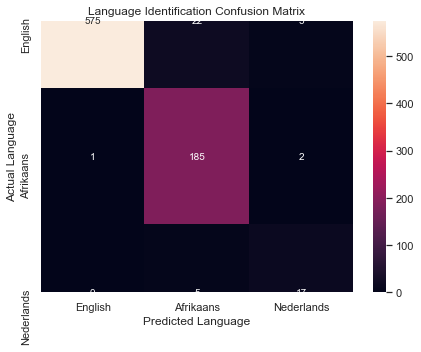

In [41]:
language_names = list(['English', 'Afrikaans', 'Nederlands'])
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, predictions)

ax = sns.heatmap(cm, annot = True, fmt = "d")

ax.set_xlabel('Predicted Language')
ax.set_ylabel('Actual Language')
ax.set_title('Language Identification Confusion Matrix')
ax.set_xticklabels(labels.values())
ax.set_yticklabels(labels.values())

[Text(0, 0.5, 'English'),
 Text(0, 1.5, 'Afrikaans'),
 Text(0, 2.5, 'Nederlands')]

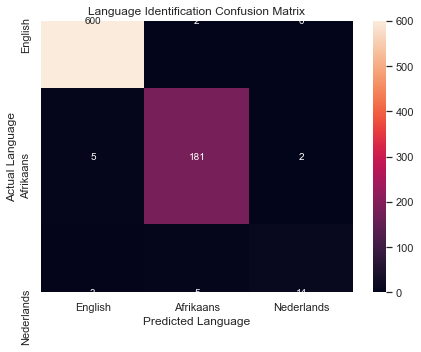

In [42]:
language_names = list(['English', 'Afrikaans', 'Nederlands'])
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, predictions2)

ax = sns.heatmap(cm, annot = True, fmt = "d")

ax.set_xlabel('Predicted Language')
ax.set_ylabel('Actual Language')
ax.set_title('Language Identification Confusion Matrix')
ax.set_xticklabels(labels.values())
ax.set_yticklabels(labels.values())

[Text(0, 0.5, 'English'),
 Text(0, 1.5, 'Afrikaans'),
 Text(0, 2.5, 'Nederlands')]

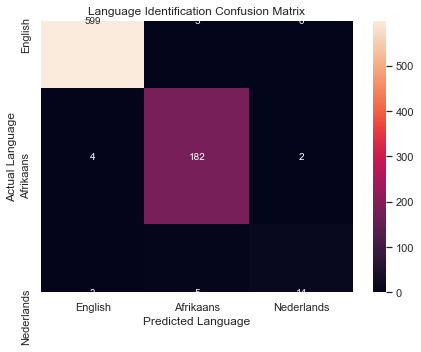

In [43]:
language_names = list(['English', 'Afrikaans', 'Nederlands'])
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, predictions3)

ax = sns.heatmap(cm, annot = True, fmt = "d")

ax.set_xlabel('Predicted Language')
ax.set_ylabel('Actual Language')
ax.set_title('Language Identification Confusion Matrix')
ax.set_xticklabels(labels.values())
ax.set_yticklabels(labels.values())

Confusion matrix, without normalization
[[575  22   5]
 [  1 185   2]
 [  0   5  17]]
Normalized confusion matrix
[[0.9551495  0.03654485 0.00830565]
 [0.00531915 0.98404255 0.0106383 ]
 [0.         0.22727273 0.77272727]]


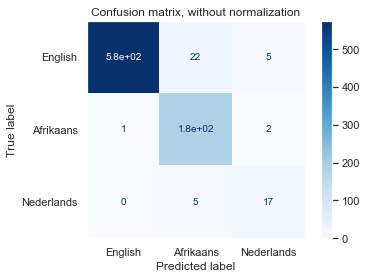

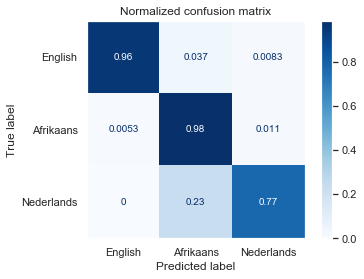

In [44]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names = ['English', 'Afrikaans', 'Nederlands']
for title, normalize in titles_options:
    disp = plot_confusion_matrix(text_clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    plt.grid(False)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.grid(False)
plt.show()

Confusion matrix, without normalization
[[600   2   0]
 [  5 181   2]
 [  3   5  14]]
Normalized confusion matrix
[[0.99667774 0.00332226 0.        ]
 [0.02659574 0.96276596 0.0106383 ]
 [0.13636364 0.22727273 0.63636364]]


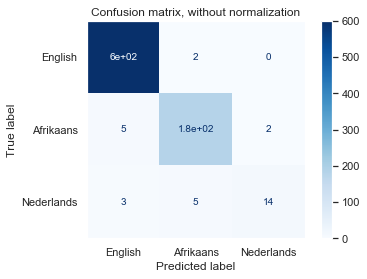

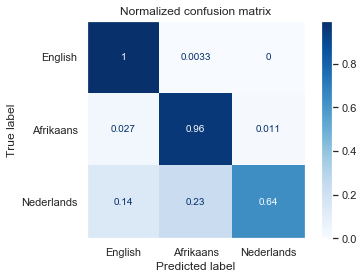

In [45]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names = ['English', 'Afrikaans', 'Nederlands']
for title, normalize in titles_options:
    disp = plot_confusion_matrix(text_clf2, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    plt.grid(False)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.grid(False)
plt.show()

Confusion matrix, without normalization
[[599   3   0]
 [  4 182   2]
 [  3   5  14]]
Normalized confusion matrix
[[0.99501661 0.00498339 0.        ]
 [0.0212766  0.96808511 0.0106383 ]
 [0.13636364 0.22727273 0.63636364]]


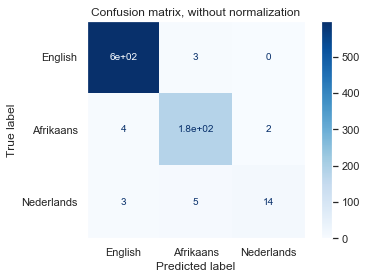

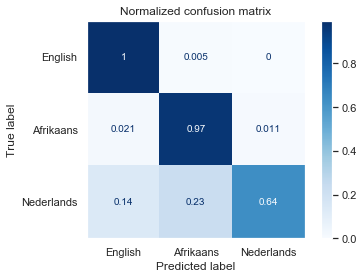

In [46]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names = ['English', 'Afrikaans', 'Nederlands']
for title, normalize in titles_options:
    disp = plot_confusion_matrix(text_clf3, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    plt.grid(False)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.grid(False)
plt.show()

<h1> 21x21 Confusion Matrix</h1>

<p> 
The well defined diagonal is a visual representation 
of the good performance of this language classifier.
Although this model performs quite well, there are a few misclassifications.
The confusion matrix gives insight into where the model makes errors.
</p>

In [47]:
# Visualize Performance

test_languages(X_test, y_test, predictions)

Prediction: English
Actual Language: English
Input Sentence: 
the chickens come home to roost


Prediction: English
Actual Language: English
Input Sentence: 
go off halfcocked


Prediction: English
Actual Language: English
Input Sentence: 
designer stubble


Prediction: English
Actual Language: English
Input Sentence: 
high five


Prediction: English
Actual Language: English
Input Sentence: 
bone idle


Prediction: English
Actual Language: English
Input Sentence: 
away with the fairies


Prediction: English
Actual Language: English
Input Sentence: 
going to hell in a handbasket


Prediction: English
Actual Language: English
Input Sentence: 
good riddance


Prediction: Afrikaans
Actual Language: Afrikaans
Input Sentence: 
hy maak of hy geld in die bank het


Prediction: English
Actual Language: English
Input Sentence: 
dock your pay


Prediction: English
Actual Language: English
Input Sentence: 
billy no mates


Prediction: English
Actual Language: English
Input Sentence: 
clean breast 

so skaars soos ‘n tweedehandse doodkis


Prediction: English
Actual Language: English
Input Sentence: 
quotations


Prediction: Nederlands
Actual Language: Nederlands
Input Sentence: 
de pot verwijt de ketel dat hij zwart ziet


Prediction: Afrikaans
Actual Language: Afrikaans
Input Sentence: 
vergelyk eers wat jy het met wat jy nie het nie – dan kan jy waardeer wat jy nie het nie en liefkry wat jy het


Prediction: English
Actual Language: English
Input Sentence: 
fall from grace


Prediction: English
Actual Language: English
Input Sentence: 
swing for you


Prediction: Afrikaans
Actual Language: Afrikaans
Input Sentence: 
die henne wat die meeste kekkel lê nie die meeste eiers nie


Prediction: English
Actual Language: English
Input Sentence: 
age before beauty


Prediction: Afrikaans
Actual Language: Afrikaans
Input Sentence: 
nooit gedink my blindederm sal lank genoeg wees nie


Prediction: English
Actual Language: English
Input Sentence: 
when pigs fly


Prediction: Afrikaans
Actu

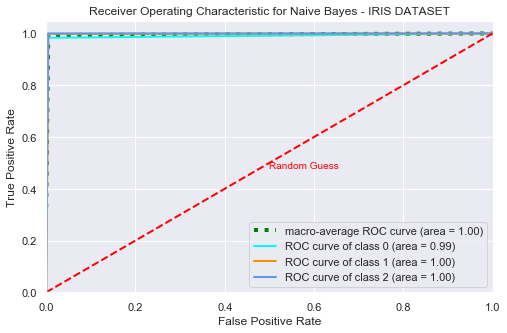

In [53]:
from scipy import interp
from itertools import cycle

pred1=text_clf.predict(X_train)
t1=sum(x==0 for x in pred1-y_train)/len(pred1)

### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_train))[:, i], np.array(pd.get_dummies(pred1))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Naive Bayes - IRIS DATASET')
plt.legend(loc="lower right")
plt.show()

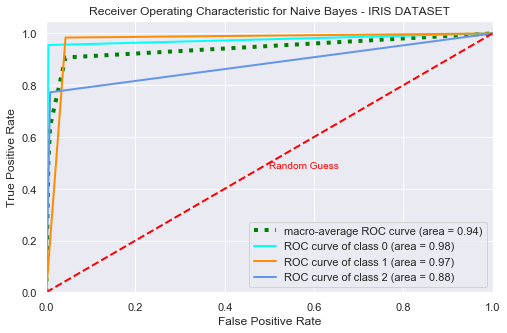

In [49]:
from scipy import interp
from itertools import cycle

pred1=text_clf.predict(X_test)
t1=sum(x==0 for x in pred1-y_test)/len(pred1)

### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(pred1))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Naive Bayes - IRIS DATASET')
plt.legend(loc="lower right")
plt.show()

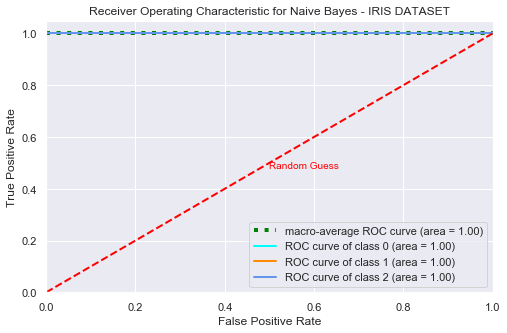

In [54]:
from scipy import interp
from itertools import cycle

pred1=text_clf2.predict(X_train)
t1=sum(x==0 for x in pred1-y_train)/len(pred1)

### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_train))[:, i], np.array(pd.get_dummies(pred1))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Naive Bayes - IRIS DATASET')
plt.legend(loc="lower right")
plt.show()

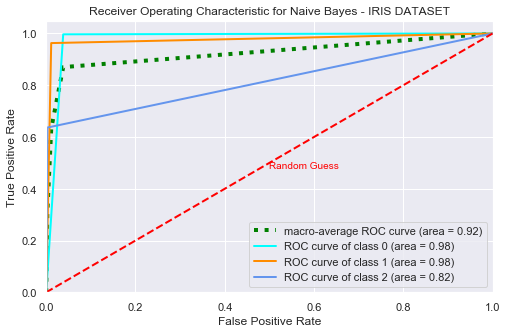

In [50]:
from scipy import interp
from itertools import cycle

pred1=text_clf2.predict(X_test)
t1=sum(x==0 for x in pred1-y_test)/len(pred1)

### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(pred1))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Naive Bayes - IRIS DATASET')
plt.legend(loc="lower right")
plt.show()

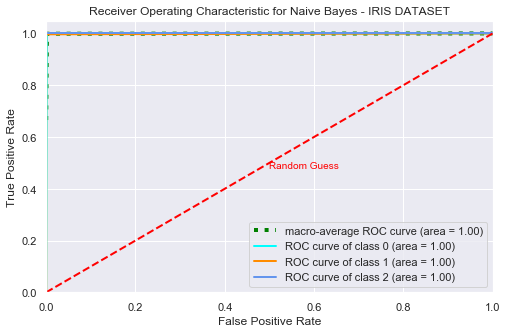

In [55]:
from scipy import interp
from itertools import cycle

pred1=text_clf3.predict(X_train)
t1=sum(x==0 for x in pred1-y_train)/len(pred1)

### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_train))[:, i], np.array(pd.get_dummies(pred1))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Naive Bayes - IRIS DATASET')
plt.legend(loc="lower right")
plt.show()

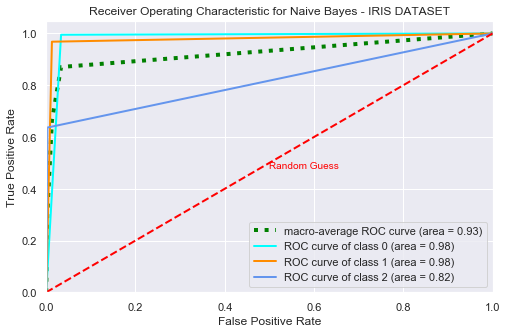

In [51]:
from scipy import interp
from itertools import cycle

pred1=text_clf3.predict(X_test)
t1=sum(x==0 for x in pred1-y_test)/len(pred1)

### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(pred1))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Naive Bayes - IRIS DATASET')
plt.legend(loc="lower right")
plt.show()